In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import matplotlib
import time
import scanpy as sc
import sklearn
import networkx as nx
import ot
import paste as pst
from paste.helper import to_dense_array
import anndata

%load_ext autoreload
%autoreload 2
# style.use('seaborn-dark')
style.use('seaborn-white')

## Organize data

In [2]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {sample:sc.read_h5ad('../data/DLPFC/{0}_preprocessed.h5'.format(sample)) for sample in sample_list}
sample_groups = [["151507", "151508", "151509","151510"],[ "151669", "151670","151671", "151672"],[ "151673","151674", "151675", "151676"]]
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

# Center intergartion

### Organize

In [3]:
group_idx=2

initial_layer_indices =  [(0,2),(1,2),(2,1)]
initial_layer = [layer_groups[j][i] for j,i in initial_layer_indices]
lmbda = len(layer_groups[group_idx])*[1/len(layer_groups[group_idx])]
initial_layer = layer_groups[group_idx]

### Initial spatial pis

In [4]:
init_pis = [pst.match_spots_using_spatial_heuristic(np.array(initial_layer[1].obsm['spatial']),layer_groups[group_idx][i].obsm['spatial'],use_ot=True) for i in range(len(layer_groups[group_idx]))]


### Run center integration

In [133]:
start = time.time()
center_layer, pis = pst.center_align(initial_layer, layer_groups[group_idx], lmbda, alpha=0.1,random_seed=2,norm=True,verbose=True, pis_init=init_pis)
end = time.time()
print('time',end-start)
# cache output to file to load for subsequent runs as run time of above cell is quite long (~2hours on a laptop)
center_layer.write("../data/DLPFC/center2_a0.1_KL_seed2.h5ad")

Filtered all slices for common genes. There are 10487 common genes.
Epoch 10 reached after 12.850 seconds, error: 3008.228034
Epoch 20 reached after 24.367 seconds, error: 2911.400084
Epoch 30 reached after 35.961 seconds, error: 2898.598159
Epoch 40 reached after 47.502 seconds, error: 2888.274238
Epoch 50 reached after 59.196 seconds, error: 2879.154253
Epoch 60 reached after 70.789 seconds, error: 2872.177668
Epoch 70 reached after 82.396 seconds, error: 2866.962381
Epoch 80 reached after 94.154 seconds, error: 2863.184367
Epoch 90 reached after 106.224 seconds, error: 2860.514436
Epoch 100 reached after 117.933 seconds, error: 2858.553338
Epoch 110 reached after 129.607 seconds, error: 2857.007831
Epoch 120 reached after 141.303 seconds, error: 2855.722172
Epoch 130 reached after 153.217 seconds, error: 2854.626079
Epoch 140 reached after 164.976 seconds, error: 2853.684859
Epoch 150 reached after 176.750 seconds, error: 2852.874844
Epoch 160 reached after 188.494 seconds, error: 2

### Oranize output

In [12]:
center_layer = sc.read_h5ad("../data/DLPFC/center-layer.h5ad")
B = initial_layer[1].shape[0]*sum([0.25*np.dot(pis[i], to_dense_array(layer_groups[group_idx][i][:,center_layer.var_names].X)) for i in range(4)])
center_layer_ = initial_layer[1].copy()[:,center_layer.var_names]
center_layer_.X = B

/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


# Analysis

### Draw spatial expression

initial layer


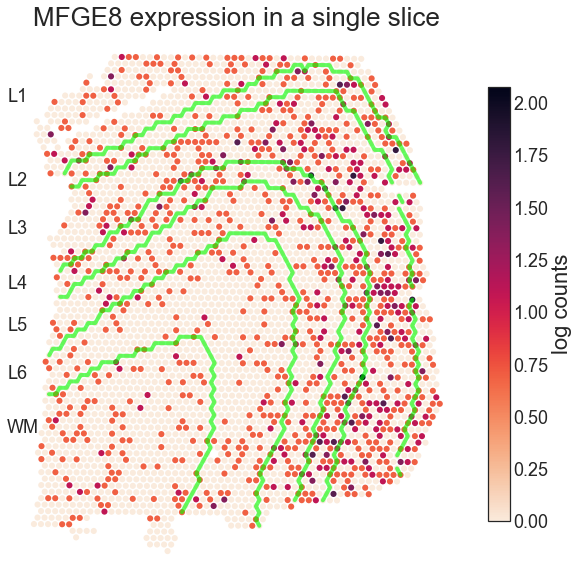

center layer


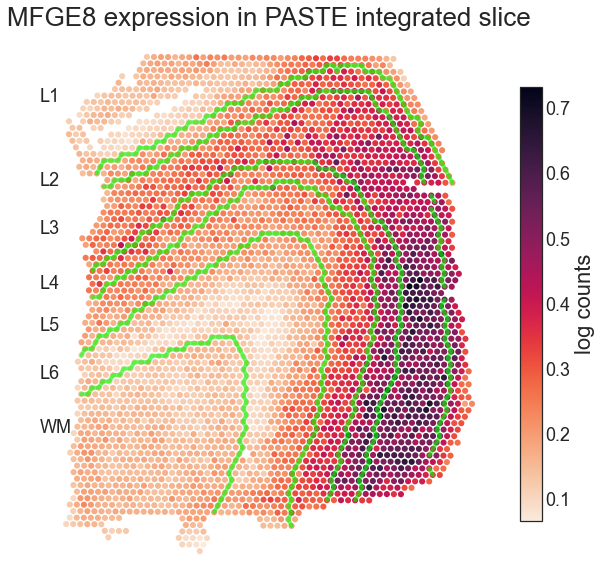

In [9]:
plt.rcParams.update({'font.size': 18})

def get_scatter_contours(layer,labels,interest = ['WM']):
    idx = np.array(range(len(labels)))[(labels.isin(interest)).to_numpy()]
    idx_not =  np.array(range(len(labels)))[(labels.isin(set(labels.cat.categories).difference(interest))).to_numpy()]
    dist = scipy.spatial.distance_matrix(layer.obsm['spatial'],layer.obsm['spatial'])
    min_dist = np.min(dist[dist>0])
    eps = 0.01
    edges = np.zeros(dist.shape)
    edges[dist>0] = (dist[dist>0]-min_dist)**2<eps
    border = list(filter(lambda x: np.sum(edges[x,idx_not]>0),idx))
    j = np.argmin(layer.obsm['spatial'][border,0])
    contours,left = [[border[j]]],set(border).difference(set([border[j]]))
    for i in range(1,len(border)):
        last = contours[-1][-1]
        neighbors = set(left).intersection(np.where((dist[last,:]-min_dist)**2<eps)[0])
        if len(neighbors)>0:
            j = neighbors.pop()
            contours[-1].append(j)
        else:
            l = list(left)
            j = l[np.argmin(layer.obsm['spatial'][l,0])]
            contours.append([j])
        left = left.difference(set([j]))
    return contours

def plot_2d_expression(layer,gene, adatas, sample_list,name="",title='',vmin=None,vmax=None,layer_idx=None,norm=False,draw_contours=True):
    cmap = sns.color_palette("rocket_r", as_cmap=True) #sns.color_palette("magma", as_cmap=True) #sns.cubehelix_palette(as_cmap=True)
    fig = plt.figure(figsize=(10,10))
    v = to_dense_array(layer[:,gene].X).copy().ravel() + 1
    if norm: v = v/layer.gene_exp.sum(axis=1)
    v = np.log(v)
    scat = plt.scatter(layer.obsm['spatial'][:,0],layer.obsm['spatial'][:,1],linewidth=0,s=150, marker=".",c=v,cmap=cmap,vmin=vmin,vmax=vmax)
    plt.gca().set_title(title, fontsize=26)
    cbar = plt.colorbar(scat,shrink=0.8)#, location='right')
    cbar.ax.set_ylabel('log counts',fontsize=22)
    plt.axis('off')
    plt.gca().invert_yaxis()
 
    if draw_contours:
        for l in ['Layer{}'.format(i) for i in [1,3,5]]+['WM']:
            contours = get_scatter_contours(layer,adatas[sample_list[2*4+1]].obs['layer_guess_reordered'],[l])
            for k in range(len(contours)):
                plt.plot(layer.obsm['spatial'][contours[k], 0], layer.obsm['spatial'][contours[k], 1], 'lime',lw=4,alpha=0.6)
    
    plt.gca().text(110,150,'L1')
    plt.gca().text(110,220,'L2')
    plt.gca().text(110,260,'L3')
    plt.gca().text(110,305,'L4')
    plt.gca().text(110,340,'L5')
    plt.gca().text(110,380,'L6')
    plt.gca().text(110,425,'WM')
       
    plt.show()
    return

for gene in ['MFGE8']:
    vmin = None
    vmax = None
    layer_idx = None
    print('initial layer')
    plot_2d_expression(initial_layer[1],gene,adatas, sample_list,name="initial_layer_{0}".format(gene),vmin=vmin,vmax=vmax,title = '{} expression in a single slice'.format(gene),layer_idx=layer_idx)
    print('center layer')
    plot_2d_expression(center_layer,gene,adatas, sample_list,name="center_layer_{0}".format(gene),vmin=vmin,vmax=vmax,title='{} expression in PASTE integrated slice'.format(gene),layer_idx=layer_idx)
    #print('center layer')
    #plot_2d_expression(center_layer_,gene,adatas, sample_list,name="_center_layer_{0}".format(gene),vmin=vmin,vmax=vmax,title='{0} expression in prefrontal cortex (PASTE integrated slice NO NMF)'.format(gene),layer_idx=layer_idx)


### Clustering

In [10]:
from sklearn.cluster import KMeans

def match_cluster_labels(true_labels,est_labels):
    true_labels_arr = np.array(list(true_labels))
    est_labels_arr = np.array(list(est_labels))
    org_cat = list(np.sort(list(pd.unique(true_labels))))
    est_cat = list(np.sort(list(pd.unique(est_labels))))
    B = nx.Graph()
    B.add_nodes_from([i+1 for i in range(len(org_cat))], bipartite=0)
    B.add_nodes_from([-j-1 for j in range(len(est_cat))], bipartite=1)
    for i in range(len(org_cat)):
        for j in range(len(est_cat)):
            weight = np.sum((true_labels_arr==org_cat[i])* (est_labels_arr==est_cat[j]))
            B.add_edge(i+1,-j-1, weight=-weight)
    match = nx.algorithms.bipartite.matching.minimum_weight_full_matching(B)
#     match = minimum_weight_full_matching(B)
    if len(org_cat)>=len(est_cat):
        return np.array([match[-est_cat.index(c)-1]-1 for c in est_labels_arr])
    else:
        unmatched = [c for c in est_cat if not (-est_cat.index(c)-1) in match.keys()]
        l = []
        for c in est_labels_arr:
            if (-est_cat.index(c)-1) in match: 
                l.append(match[-est_cat.index(c)-1]-1)
            else:
                l.append(len(org_cat)+unmatched.index(c))
        return np.array(l)

def cluster_adata(adata,n_clusters=7,sample_name=''):
    adata_copy = adata.copy()
    sc.pp.normalize_total(adata_copy, inplace=True)
    sc.pp.log1p(adata_copy)
    sc.pp.highly_variable_genes(adata_copy, flavor="seurat", n_top_genes=2000)
    sc.pp.pca(adata_copy)
    
    model = sklearn.decomposition.NMF(n_components=50)
    adata_copy.obsm['X_pca'] = model.fit_transform(adata_copy.X)
    
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=0,n_init=500).fit_predict(adata_copy.obsm['X_pca'])
    
    adata_copy.obs['my_clusters'] = pd.Series(1+match_cluster_labels(adata_copy.obs['layer_guess_reordered'],cluster_labels),index=adata_copy.obs.index,dtype='category')
    
    ari = sklearn.metrics.adjusted_rand_score(adata_copy.obs['layer_guess_reordered'],adata_copy.obs['my_clusters'])
    print('ARI',ari)   
    adata.obs['my_clusters'] = adata_copy.obs['my_clusters'].copy() 
    return

plt.rcParams.update({'font.size': 22})
def draw_spatial(adata,clusters='my_clusters',sample_name='',draw_contours=False):
    fig = plt.figure(figsize=(12,10))
    ax = sc.pl.spatial(adata, color=clusters, spot_size=5,show=False,palette=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d'],ax=plt.gca())
    ax[0].axis('off')
    ari = sklearn.metrics.adjusted_rand_score(adata.obs['layer_guess_reordered'],adata.obs[clusters])
    ax[0].legend(title='Cluster',bbox_to_anchor=(0.9, 0.9),fontsize=20,title_fontsize=20)
    ax[0].set_title('{}: ARI={:.2f}'.format(sample_name,ari),fontsize=26)
    if draw_contours:
        for l in ['Layer{}'.format(i) for i in [1,3,5]]+['WM']:
            contours = get_scatter_contours(adata,adata.obs['layer_guess_reordered'],[l])
            for k in range(len(contours)):
                plt.plot(adata.obsm['spatial'][contours[k], 0], adata.obsm['spatial'][contours[k], 1], 'lime', #dict(zip(['Layer{}'.format(i) for i in range(1,7)]+['WM'],adata.uns['layer_guess_reordered_colors']))[l],
                         lw=4,alpha=0.6)
    plt.gca().text(105,150,'L1')
    plt.gca().text(105,220,'L2')
    plt.gca().text(105,260,'L3')
    plt.gca().text(105,305,'L4')
    plt.gca().text(105,340,'L5')
    plt.gca().text(105,380,'L6')
    plt.gca().text(105,425,'WM')
    plt.show()

151674


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


ARI 0.2369810915709726


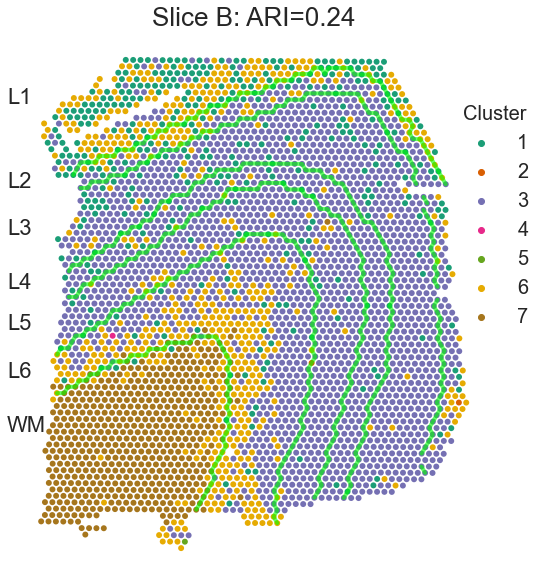

In [11]:
for s in ["151674"]:
    adata = adatas[s]
    print(s)
    cluster_adata(adata,7,sample_name=s)
    draw_spatial(adata,'my_clusters',{"151673":'Slice A',"151674":'Slice B', "151675":'Slice C', "151676":'Slice D'}[s],draw_contours=True)

/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


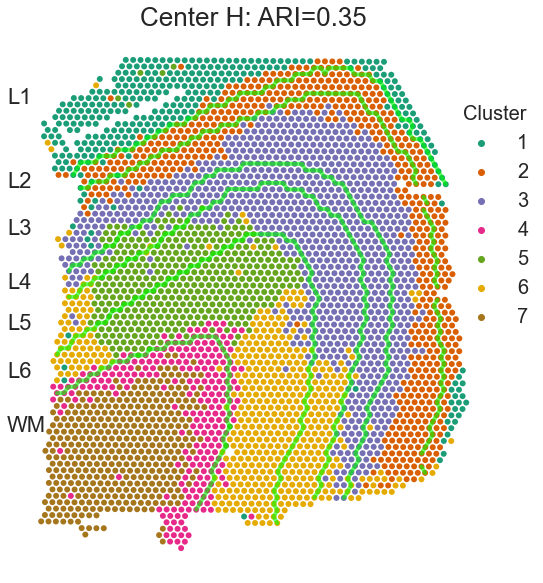

In [14]:
W = center_layer.uns['paste_W']
H = center_layer.uns['paste_H']
W = (W.T/W.sum(axis=1)).T
paste_cluster_labels = KMeans(n_clusters=7, random_state=0, n_init=500).fit_predict(W)
center_adata = adatas['151674'].copy()
center_adata = center_adata[:,center_layer.var_names]

center_adata.X = center_layer.X
center_layer.obs['clustering_W'] = pd.Series(1+match_cluster_labels(center_adata.obs['layer_guess_reordered'],paste_cluster_labels),index=center_adata.obs.index,dtype='category')
draw_spatial(center_layer,"clustering_W",'Center H',draw_contours=True)


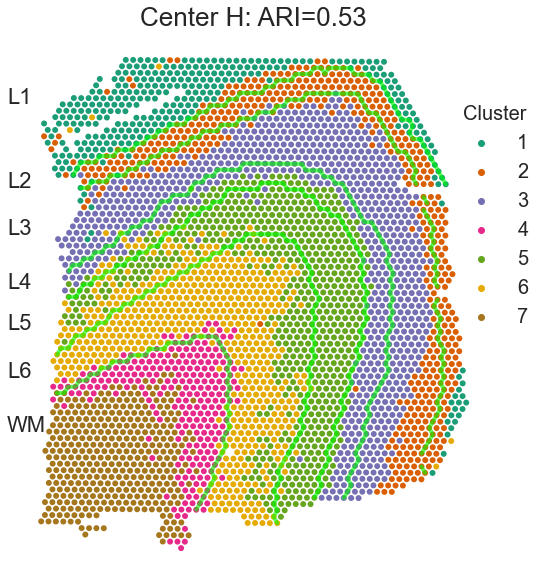

In [53]:
draw_spatial(center_layer,"clustering_W",'Center H',draw_contours=True)